In [2]:
%load_ext autoreload
%autoreload 2
from utils import *
import pickle
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
f = open("communities/partition_1", "rb")
partition = pickle.load(f)
f.close()

In [4]:
values = list(partition.values())

In [5]:
c = Counter(values)
groups_sorted = sorted(np.unique(values), key=c.get, reverse=True)

In [6]:
groups_counts = []
for group_id in groups_sorted:
    groups_counts.append((group_id, c[group_id]))
groups_counts = np.array(groups_counts)

In [7]:
groups_counts

array([[  0, 722],
       [  6, 587],
       [  8, 562],
       ...,
       [702,   1],
       [704,   1],
       [705,   1]])

In [9]:
groups_filtered = groups_counts[:3]

In [10]:
groups_filtered[:,0]

array([0, 6, 8])

In [11]:
f = open("communities/nb_tweets_per_user_1", "rb")
nb_tweets_per_user = pickle.load(f)
f.close()

In [12]:
f = open("communities/graph_1", "rb")
G = pickle.load(f)
f.close()

In [13]:
partition_filtered = dict()
G_filtered = G.copy()
nb_tweets_per_user_filtered = dict()
for user_id, group in partition.items():
    if group in groups_filtered[:,0]:
        partition_filtered[user_id] = group
        nb_tweets_per_user_filtered[user_id] = nb_tweets_per_user[user_id]
    else:
        G_filtered.remove_node(user_id)

In [14]:
pos = community_layout(G_filtered, partition_filtered)

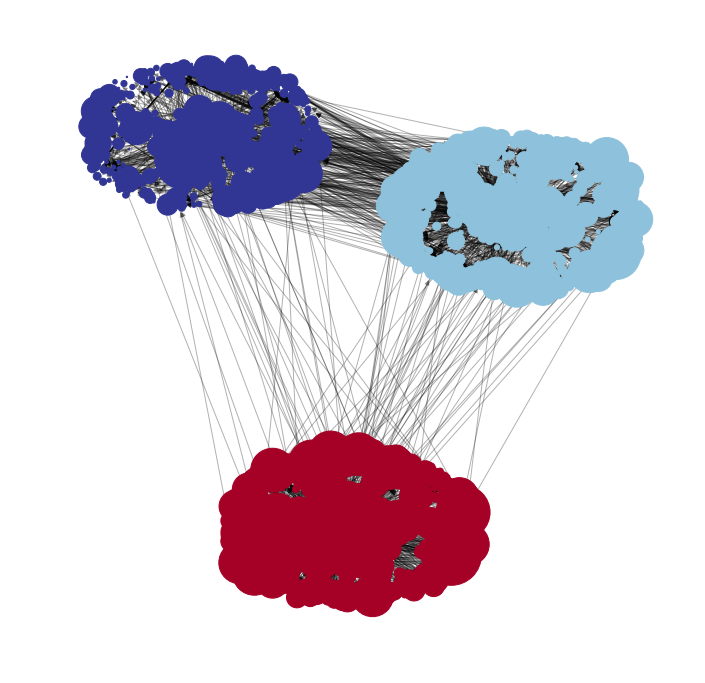

In [15]:
plt.figure(figsize=(12, 12))
'''nx.draw_networkx_nodes(G_filtered, pos, node_size=list(nb_tweets_per_user_filtered.values()),\
                       cmap=plt.cm.RdYlBu, node_color=list(partition_filtered.values()))
'''
nx.draw_networkx_nodes(G_filtered, pos, node_size=[nb_tweets_per_user_filtered.get(node) for node in G_filtered.nodes()],\
                       cmap=plt.cm.RdYlBu, node_color=[partition_filtered.get(node) for node in G_filtered.nodes()])
nx.draw_networkx_edges(G_filtered, pos, alpha=0.3)
plt.axis('off')
plt.show(G_filtered)

In [22]:
partition_list = [(user_id, group) for (user_id,group) in partition.items()]
partition_array = np.array(partition_list)

In [23]:
partition_array

array([[784769137956495360,                  1],
       [795961766421364737,                 22],
       [701784429618978818,                  8],
       ...,
       [        1220853756,                  6],
       [776612367966756864,                  8],
       [         321472288,                  2]])

In [27]:
top_groups = groups_filtered[:,0]
top_groups

array([0, 6, 8])

In [25]:
top_groups_partition = partition_array[np.where(np.in1d(partition_array[:,1], top_groups))]

In [31]:
nb_tweets_array = np.array([(user_id, nb) for (user_id, nb) in nb_tweets_per_user.items()])

In [48]:
first_group_partition = top_groups_partition[np.where(top_groups_partition[:,1] == top_groups[0])]
second_group_partition = top_groups_partition[np.where(top_groups_partition[:,1] == top_groups[1])]
third_group_partition = top_groups_partition[np.where(top_groups_partition[:,1] == top_groups[2])]

In [45]:
np.mean(nb_tweets_array[np.where(np.in1d(nb_tweets_array[:,0], first_group_partition[:,0]))][:,1])

301.51662049861494

In [49]:
np.mean(nb_tweets_array[np.where(np.in1d(nb_tweets_array[:,0], second_group_partition[:,0]))][:,1])

238.42930153321976

In [50]:
np.mean(nb_tweets_array[np.where(np.in1d(nb_tweets_array[:,0], third_group_partition[:,0]))][:,1])

156.32562277580072

### 1ère communauté

In [41]:
first_group_users = tuple(first_group_partition[:,0])

In [90]:
twitter_db = connect_to_db()
cursor = twitter_db.cursor()

query = ("SELECT text, candidates\
        FROM tweets\
        WHERE lang='fr' AND \
        (user_id IN " + str(first_group_users) + " OR \
        in_reply_to_user_id IN " + str(first_group_users) + " OR \
        quoted_user_id IN " + str(first_group_users) + " OR \
        retweeted_user_id IN " + str(first_group_users)) + ") LIMIT 10000"

cursor.execute(query)

In [94]:
first_group_tweets = []
first_group_candidates = []
for tweet, cand in cursor:
    first_group_tweets.append(tweet)
    first_group_candidates.append(list(cand))
cursor.close()

True

In [100]:
first_group_candidates = np.array(first_group_candidates).astype(int)

In [101]:
first_group_candidates[:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [102]:
first_group_tweets[:5]

["@SlmLyon @BobLeCentriste Être de gauche, c'est avoir du respect pour tous, et pas le mépris social affiché par macron",
 "RT @Simonnet2: C'est grossier @BFMTV de citer l'institut Montaigne pour évaluer les programmes ! L'ex PDG De Castries d'Axa et pro Fillon l…",
 "@Ecogine2 @RomainLesenne @JAMmontpellier @Chamade69 j'en ai pas mais j'ai autre chose https://t.co/36Gcb6zA50",
 'RT @etudiants_jlm: La vérité sur la "Révolution fiscale" que nous souhaitons avec Jean-Luc Mélenchon, par @FranceInfo.\nPARTAGEZ !… ',
 'Pr%C3%A9sidentielle+2017+%3A+au+Portugal%2C+Beno%C3%AEt+Hamon+parle+l%C3%A9galisation+du+cannabis via @cnewsmatin']

In [105]:
np.argmax(np.sum(first_group_candidates, axis=0))

9

Candidat 10 : Mélenchon

### 2ème communauté

In [106]:
second_group_users = tuple(second_group_partition[:,0])

In [107]:
twitter_db = connect_to_db()
cursor = twitter_db.cursor()

query = ("SELECT text, candidates\
        FROM tweets\
        WHERE lang='fr' AND \
        (user_id IN " + str(second_group_users) + " OR \
        in_reply_to_user_id IN " + str(second_group_users) + " OR \
        quoted_user_id IN " + str(second_group_users) + " OR \
        retweeted_user_id IN " + str(second_group_users)) + ") LIMIT 10000"

cursor.execute(query)

In [108]:
second_group_tweets = []
second_group_candidates = []
for tweet, cand in cursor:
    second_group_tweets.append(tweet)
    second_group_candidates.append(list(cand))
cursor.close()

True

In [109]:
second_group_candidates = np.array(second_group_candidates).astype(int)

In [111]:
np.sum(second_group_candidates, axis=0)

array([   9,  148,   29,  148, 4391,  346,   10, 1010, 4485,  849,    2])

In [110]:
np.argmax(np.sum(second_group_candidates, axis=0))

8

Candidat 9 : Macron

### 3ème communauté

In [113]:
third_group_users = tuple(third_group_partition[:,0])

In [114]:
twitter_db = connect_to_db()
cursor = twitter_db.cursor()

query = ("SELECT text, candidates\
        FROM tweets\
        WHERE lang='fr' AND \
        (user_id IN " + str(third_group_users) + " OR \
        in_reply_to_user_id IN " + str(third_group_users) + " OR \
        quoted_user_id IN " + str(third_group_users) + " OR \
        retweeted_user_id IN " + str(third_group_users)) + ") LIMIT 10000"

cursor.execute(query)

In [115]:
third_group_tweets = []
third_group_candidates = []
for tweet, cand in cursor:
    third_group_tweets.append(tweet)
    third_group_candidates.append(list(cand))
cursor.close()

True

In [116]:
third_group_candidates = np.array(third_group_candidates).astype(int)

In [117]:
np.argmax(np.sum(third_group_candidates, axis=0))

7

Candidat 8 : Marine Le Pen

## TO DO :
- importer un vectorizer
- transformer les tweets en vecteurs
- faire la distance des tweets intra-communauté et inter-communauté
- nettoyer le code